# Log
- optimization averege across different confusion matrices - that seems to have a big effect on the performance of enabling surrogate

# TODO
 - keep the confusion matrix estimation same - across all trials?
 - double check that params are getting properly propagated for the Agent and environment
 - ~~grid search for parameters~~
 - figure out parameters in surrogate rewards
 - ~~make rewards non binary in environment and surrogate rewards~~
 - ~~add deceay from papers, log and other~~
 - initiate q-table at `-1`?
 - run experiment with different `correct_action`
 - should we be setting up the glove for `very distinguishable` levels? Shouldn't we set it up with `barely distinguishable` levels, as this is where the perturbed rewards come on - they'd help us get through the noise and find the correct level.

# Scripts

In [1]:
import numpy as np
import collections
import pandas as pd
import argparse
import time
import numpy as np

In [2]:
import noise_estimator

In [3]:
# from ucbq_agent import UCBQAgent
from ucbq_agent_stateless import UCBQAgent
# from ucbq_environment import ModifiedRandomEnvironment
from ucbq_environment_stateless import ModifiedRandomEnvironment

# Params

In [4]:
max_steps = 120
num_episodes = 100
num_actions = 7
# start_state = 1
start_action = 0
# zero indexed
correct_action = 1

# Scripts

In [5]:
import matplotlib.pyplot as plt
from tqdm import tqdm 
import utils

In [6]:
def get_mean_across_episodes(arr):
    min_cols = np.amin([len(row) for row in arr])
    truncated_arr = [ x[:min_cols] for x in arr ]
    res = np.array(truncated_arr)
    mean = res.mean(axis=0)

    return mean    

def get_cumsum_rewards(rewards):
    cumulative_sum_rewards = np.cumsum(rewards)
    time_steps = np.arange(1, len(rewards) + 1)
    mean_rewards = cumulative_sum_rewards / time_steps
    return mean_rewards

In [7]:
from modified_pendulum_processor import ModifiedPendulumProcessor

In [8]:
def runner(adjust_rewards=None, 
           agent=None,
           env=None,
           params={}):

    agent = UCBQAgent(params=params) if agent is None else agent
    env = env if env else ModifiedRandomEnvironment()

    episode_rewards = 0
    rewards = []
    q_values_for_chart = []
    
    t = 0
    action = start_action
    state = 0
    plots = params.get('plots', True)
    noise = params.get('noise', False)
    surrogate = params.get('surrogate', False)
    surrogate_c_interval = params.get('surrogate_c_interval', 10)
    
    reward_processor = None

    # surrogate can only be with noise=True for now
    if surrogate:
        noise = True
    
    if noise: 
        #TODO: should we keep/carry over the estimated confusion matrix across all episodes?
        # num_unique_rewards = correct_action + 1
        num_unique_rewards = utils.get_num_unique_rewards(num_actions, correct_action)
        reward_processor = ModifiedPendulumProcessor(surrogate=surrogate, surrogate_c_interval=surrogate_c_interval, num_unique_rewards=num_unique_rewards)

    while True:
        if t == max_steps - 1:
            break

        action = agent.choose_action(state) 
        reward, next_state, done = env.step(action)        
        
        if done:
            break     

        rewards.append(reward)

        if noise or surrogate:
            observation, reward, done, info = reward_processor.process_step(state, reward, None, None, action)
        
        agent.learn(state, action, reward, next_state)
        episode_rewards += reward
        t += 1

        if plots:
            if t % 10 == 0:
                sum_q_values_across_states = np.around(np.sum(agent.Q, axis=0), decimals=4)
                q_values_for_chart.append(sum_q_values_across_states)
      
                
    episode_length = t + 1
    selected_action = action 
    
    if t == max_steps - 1:
        # If we reached the end of the episode
        # select the action with the highest Q-values as the correct one
        sum_q_values_across_states = np.sum(agent.Q, axis=0)
        selected_action = np.argmax(sum_q_values_across_states)

    return q_values_for_chart, rewards, episode_length, selected_action, reward_processor

In [9]:
def qLearningExperiment(learner=None, params={}):
    plots = params.get('plots', True)

    q_values_all_experiments = []
    rewards_all_experiments = []
    episode_lengths = []
    selected_actions = []

    for i in tqdm(range(num_episodes)):
        # TODO: .reset() instead of re-creating?
        agent = UCBQAgent(params=params) if learner is None else learner
        env = ModifiedRandomEnvironment(correct_action=correct_action)
        q_values_for_chart, rewards, episode_length, selected_action, reward_processor = runner(env=env, agent=agent, params=params)
        selected_actions.append(selected_action)
        episode_lengths.append(episode_length)
                
        rewards_all_experiments.append(rewards)
        q_values_all_experiments.append(q_values_for_chart)

    correct_count = selected_actions.count(correct_action)
    accuracy = (correct_count / len(selected_actions)) * 100
    
    return q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy, reward_processor


In [10]:
def plot_mean_q_values(params={}):
    q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy, last_reward_processor = qLearningExperiment(params=params)
    print(f'Accuracy: {accuracy}')    
    print(f'Mean episode length: {np.mean(episode_lengths)}')

    all_mean_rewards = [ get_cumsum_rewards(rewards) for rewards in rewards_all_experiments ]

    all_mean_rewards = pd.DataFrame(all_mean_rewards) # rewards have different lengths
    # because they terminate earlier sometimes
    mean_matrix = np.mean(all_mean_rewards, axis=0)
    mean_rewards_across_episodes = pd.DataFrame(mean_matrix)

    mean_matrix = get_mean_across_episodes(q_values_all_experiments)
    mean_q_values_across_episodes = pd.DataFrame(mean_matrix)
    if params.get('noise', False): 
        print('Last reward processor:')
        last_reward_processor.print()

    fig, axes = plt.subplots(2, 2, figsize=(8, 6))
    mean_rewards_across_episodes.plot(ax=axes[0, 0], title='Mean reward for this step across all episodes')
    mean_q_values_across_episodes.plot(ax=axes[0, 1], title='Mean Q-values accross all episodes')
    pd.DataFrame(episode_lengths).plot(ax=axes[1, 0], title='Episode lengths', marker='*')
    pd.DataFrame(selected_actions).plot(ax=axes[1, 1], title='Guessed correct action per episode', marker='*')
    plt.tight_layout()
    plt.show()

# Params

In [11]:
def default_params():
    """ These are the default parameters used in the framework. """
    return {
            # # Runner parameters
            # 'max_episodes': int(1E6),         # experiment stops after this many episodes
            # 'max_steps': int(1E9),            # experiment stops after this many steps
            # 'multi_runner': False,            # uses multiple runners if True
            # Optimization parameters
            'alpha': 0.5,                       # learning rate of optimizer
            'alpha_decay': 40,
            'alpha_min': 0.001,
            # Exploration parameters
            'epsilon': 1,               # annealing starts at this epsilon
            'epsilon_decay': 20,
            'epsilon_min': 0.01,    
            'gamma': 0.95,                    # discount factor gamma
            'plots': False,
           }

# Real rewards UCB Q-learning

In [12]:
rewards_all_experiments = []

qs, rewards, _, _, _ = runner()
rewards_all_experiments.append(rewards)

In [13]:
agent = UCBQAgent()

runner(agent=agent)
utils.print_agent_stats(agent)

Q-table:
[[-8 -6 -6 -5 -5 -6  0]]
Number of times action was taken:
[[ 2.  1.  4.  4.  3.  1. 41.]]
Total timesteps:
50


100%|██████████| 100/100 [00:00<00:00, 862.98it/s]

Accuracy: 100.0
Mean episode length: 50.0


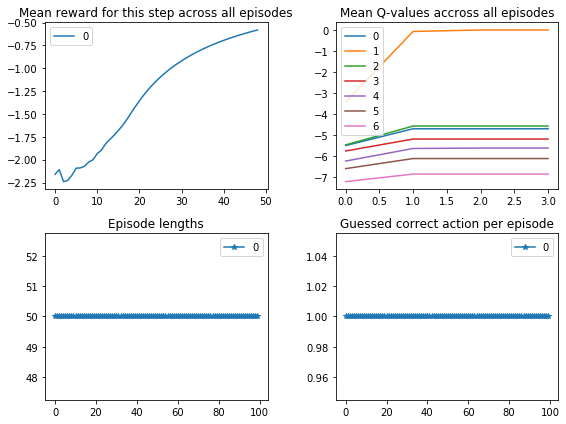

In [14]:
# The Q-value shape make sense - we're trying higher numbers later
# so they converge to -1 slower than e.g. action 0 or 1
plot_mean_q_values()

# Noisy rewards
- rewards are now noisy
- q-learner hasn't changed

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay

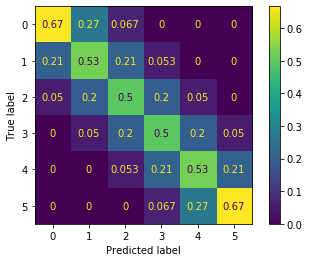

True

In [16]:
# Confusion matrix used as noise
num_unique_rewards = utils.get_num_unique_rewards(num_actions=num_actions, correct_action=correct_action)
cmat = ModifiedPendulumProcessor(num_unique_rewards=num_unique_rewards).initialize_cmat()
ConfusionMatrixDisplay(confusion_matrix=cmat).plot()
plt.show()
noise_estimator.is_invertible(cmat)

100%|██████████| 100/100 [00:00<00:00, 669.99it/s]


Accuracy: 86.0
Mean episode length: 50.34
Last reward processor:
Estimated confusion matrix:


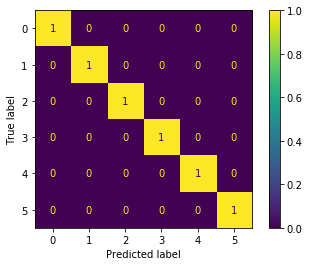

Reward sets:
{(0, 4): [-2, -2], (0, 0): [-1, -2, -1, -1], (0, 3): [-1, -2], (0, 5): [-5], (0, 6): [-5], (0, 1): [-1], (0, 2): [0, -1, -1, -1, -1, -1, -1, -2, 0, -2, -2, -1, -1, -1, -2, 0, -2, -1, -1, 0, -2, -2, -1, -2, 0, -2, -1, -1, 0, -1, 0, 0, -1, -1, -3, -1, 0, -1]}
Reward set counts:
Key (0, 4): 2 items
Key (0, 0): 4 items
Key (0, 3): 2 items
Key (0, 5): 1 items
Key (0, 6): 1 items
Key (0, 1): 1 items
Key (0, 2): 38 items


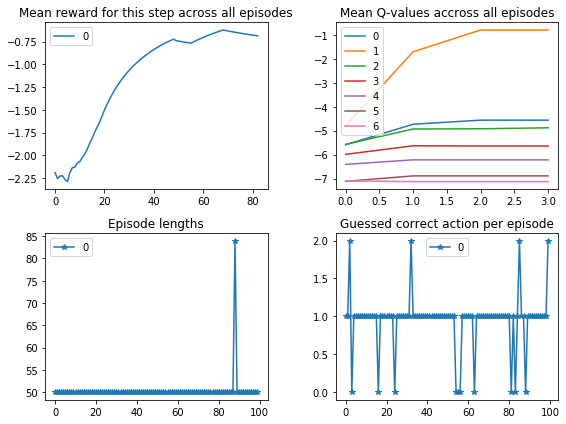

In [17]:
plot_mean_q_values(params={'noise': True})

# Surrogate rewards

100%|██████████| 100/100 [00:00<00:00, 396.83it/s]


Accuracy: 81.0
Mean episode length: 50.45
Last reward processor:
Estimated confusion matrix:


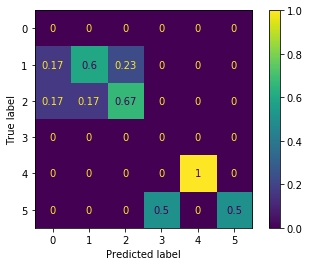

Reward sets:
{(0, 1): [0, -2, -2, -1], (0, 0): [-2, -2], (0, 4): [-5, -3], (0, 2): [-1, -1, 0, -1, -1, 0, -1, -1, -1, -2, -1, -2, -1, -1, -1, 0, -1, 0, -1, -2, 0, -1, -2, -1, -1, -1, -1, -2, -2, -2, -1, -1, -1, -1, -1, -1, -2, -1, -2], (0, 6): [-4], (0, 5): [-4]}
Reward set counts:
Key (0, 1): 4 items
Key (0, 0): 2 items
Key (0, 4): 2 items
Key (0, 2): 39 items
Key (0, 6): 1 items
Key (0, 5): 1 items


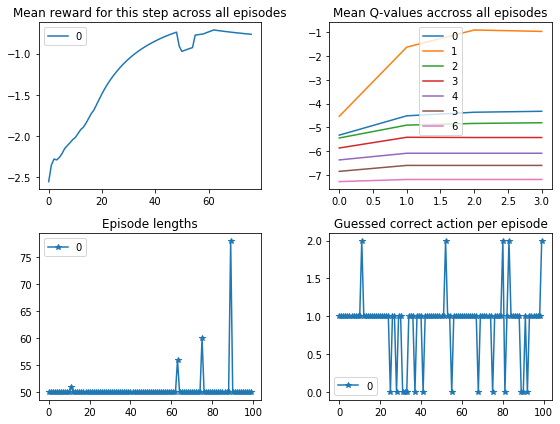

In [19]:
plot_mean_q_values(params={'noise': True, 'surrogate': True, 'surrogate_c_interval': 10})

# Sanity check

In [19]:
max_steps = 120
num_episodes = 100

params = {
    # # Runner parameters
    # 'max_episodes': int(1E6),         # experiment stops after this many episodes
    # 'max_steps': int(1E9),            # experiment stops after this many steps
    # 'multi_runner': False,            # uses multiple runners if True
    # Optimization parameters
    'alpha': 0.5,                       # learning rate of optimizer
    'alpha_decay': 40,
    'alpha_min': 0.001,
    # Exploration parameters
    'epsilon': 1,               # annealing starts at this epsilon
    'epsilon_decay': 20,
    'epsilon_min': 0.01,    
    'gamma': 0.95,                    # discount factor gamma
    'plots': False,
}

print('Accuracy should be higher, timesteps should be lower')

params['noise'] = False
params['surrogate'] = False
q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy, _ = qLearningExperiment(params=params)
mean_episode_length = np.mean(episode_lengths)
print(accuracy, mean_episode_length) 

params['noise'] = True
params['surrogate'] = False
q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy, _ = qLearningExperiment(params=params)
mean_episode_length = np.mean(episode_lengths)
print(accuracy, mean_episode_length) 

params['noise'] = True
params['surrogate'] = True
q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy, _ = qLearningExperiment(params=params)
mean_episode_length = np.mean(episode_lengths)
print(accuracy, mean_episode_length) 

Accuracy should be higher, timesteps should be lower


100%|██████████| 100/100 [00:00<00:00, 983.15it/s]


100.0 50.0


100%|██████████| 100/100 [00:00<00:00, 734.43it/s]


83.0 50.26


100%|██████████| 100/100 [00:00<00:00, 535.92it/s]

84.0 50.3


# Bayesian optimization

In [20]:
# !pip install bayesian-optimization

In [21]:
# | 24        | 100.0     | 0.9026    | 826.9     | 0.0       | 73.21     |
# this with noise True and surrogate False
# no alpha decay
# | 184       | 99.0      | 0.8236    | 243.1     | 0.5114    | 0.2529    | 70.53     | 0.04431   | 0.8871    | 67.76     |

In [22]:
max_steps = 120
num_episodes = 100

from bayes_opt import BayesianOptimization

def objective(
        alpha,
        alpha_decay,
        alpha_min,
        epsilon,
        epsilon_decay,
        epsilon_min,
        gamma,
        surrogate_c_interval,
#| 7         | 87.5      | 23.16     |

        ):
    # # 'surrogate_c_interval': [1, 2, 5, 10, 20, 40]
    # # 'surrogate_lr'    
    # convergence_number_of_consequent_actions
    # intial_q_values: [0, -7]

    # surrogate_c_interval = int(surrogate_c_interval)

    new_params = {
        'noise': True,
        'surrogate': False,
        'alpha': alpha, 
        'alpha_decay': alpha_decay,
        'alpha_min': alpha_min,
        'epsilon': epsilon, 
        'epsilon_decay': epsilon_decay,
        'epsilon_min': epsilon_min,
        'gamma': gamma,
        # 'plots': False,   
        'surrogate_c_interval': surrogate_c_interval,
    }

    params = default_params() | new_params

    # _, _, _, _, accuracy = qLearningExperiment(adjust_rewards_surrogate, params=params)
    q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy, _ = qLearningExperiment(params=params)
    
    mean_episode_length = np.mean(episode_lengths)
    print(mean_episode_length) 

    return accuracy
    # mean_episode_length = np.mean(episode_lengths)
    # return -mean_episode_length

optimizer = BayesianOptimization(
    f=objective,
    pbounds={
        'alpha': (0, 1), 
        'alpha_decay': (1, 1000),
        'alpha_min': (0, 1),
        'epsilon': (0, 1), 
        'epsilon_decay': (10, 80),
        'epsilon_min': (0, 1),
        'gamma': (0, 1),
        'surrogate_c_interval': (1, 120)
        },
    random_state=1,
)

# n_iter: How many steps of bayesian optimization you want to perform. 
# The more steps the more likely to find a good maximum you are.
# init_points: How many steps of random exploration you want to perform.
# Random exploration can help by diversifying the exploration space.
optimizer.maximize(
    init_points=100,
    n_iter=100,
)

best_params = optimizer.max['params']

print(optimizer.max)

|   iter    |  target   |   alpha   | alpha_... | alpha_min |  epsilon  | epsilo... | epsilo... |   gamma   | surrog... |
-------------------------------------------------------------------------------------------------------------------------


100%|██████████| 100/100 [00:00<00:00, 613.74it/s]


61.05
| 1         | 23.0      | 0.417     | 720.6     | 0.0001144 | 0.3023    | 20.27     | 0.09234   | 0.1863    | 42.12     |


100%|██████████| 100/100 [00:00<00:00, 336.52it/s]


120.0
| 2         | 47.0      | 0.3968    | 539.3     | 0.4192    | 0.6852    | 24.31     | 0.8781    | 0.02739   | 80.79     |


100%|██████████| 100/100 [00:00<00:00, 445.99it/s]


94.73
| 3         | 56.0      | 0.4173    | 559.1     | 0.1404    | 0.1981    | 66.05     | 0.9683    | 0.3134    | 83.39     |


100%|██████████| 100/100 [00:00<00:00, 627.68it/s]


66.95
| 4         | 23.0      | 0.8764    | 894.7     | 0.08504   | 0.03905   | 21.89     | 0.8781    | 0.09835   | 51.11     |


100%|██████████| 100/100 [00:00<00:00, 349.83it/s]


117.7
| 5         | 53.0      | 0.9579    | 533.6     | 0.6919    | 0.3155    | 58.06     | 0.8346    | 0.01829   | 90.27     |


100%|██████████| 100/100 [00:00<00:00, 339.21it/s]


119.24
| 6         | 66.0      | 0.9889    | 748.4     | 0.2804    | 0.7893    | 17.23     | 0.4479    | 0.9086    | 35.94     |


100%|██████████| 100/100 [00:00<00:00, 390.93it/s]


104.9
| 7         | 50.0      | 0.2878    | 130.9     | 0.01937   | 0.6788    | 24.81     | 0.2655    | 0.4916    | 7.35      |


100%|██████████| 100/100 [00:00<00:00, 335.49it/s]


119.62
| 8         | 50.0      | 0.5741    | 147.6     | 0.5893    | 0.6998    | 17.16     | 0.4141    | 0.6944    | 50.29     |


100%|██████████| 100/100 [00:00<00:00, 340.95it/s]


120.0
| 9         | 38.0      | 0.04995   | 536.4     | 0.6638    | 0.5149    | 76.12     | 0.5866    | 0.9034    | 17.36     |


100%|██████████| 100/100 [00:00<00:00, 479.55it/s]


85.47
| 10        | 37.0      | 0.1393    | 807.6     | 0.3977    | 0.1654    | 74.93     | 0.3478    | 0.7508    | 87.39     |


100%|██████████| 100/100 [00:00<00:00, 351.42it/s]


119.8
| 11        | 69.0      | 0.8833    | 624.0     | 0.7509    | 0.3489    | 28.89     | 0.8959    | 0.4281    | 115.8     |


100%|██████████| 100/100 [00:00<00:00, 329.34it/s]


120.0
| 12        | 59.0      | 0.6634    | 622.1     | 0.1147    | 0.9495    | 41.49     | 0.5784    | 0.4081    | 29.21     |


100%|██████████| 100/100 [00:00<00:00, 342.92it/s]


120.0
| 13        | 71.0      | 0.9034    | 574.1     | 0.00287   | 0.6171    | 32.87     | 0.5271    | 0.8859    | 43.52     |


100%|██████████| 100/100 [00:00<00:00, 354.06it/s]


120.0
| 14        | 51.0      | 0.9085    | 623.7     | 0.01582   | 0.9294    | 58.36     | 0.9973    | 0.1723    | 17.32     |


100%|██████████| 100/100 [00:00<00:00, 329.03it/s]


120.0
| 15        | 61.0      | 0.9326    | 697.1     | 0.066     | 0.7555    | 62.77     | 0.923     | 0.7115    | 15.79     |


100%|██████████| 100/100 [00:00<00:00, 405.34it/s]


101.96
| 16        | 26.0      | 0.01988   | 27.18     | 0.02831   | 0.2462    | 70.2      | 0.5388    | 0.5528    | 101.2     |


100%|██████████| 100/100 [00:00<00:00, 772.19it/s]


51.36
| 17        | 73.0      | 0.1242    | 279.9     | 0.5858    | 0.9696    | 49.27     | 0.01865   | 0.8006    | 28.72     |


100%|██████████| 100/100 [00:00<00:00, 424.87it/s]


98.28
| 18        | 75.0      | 0.8071    | 388.5     | 0.8635    | 0.7471    | 48.94     | 0.1365    | 0.05992   | 15.44     |


100%|██████████| 100/100 [00:00<00:00, 804.34it/s]


50.06
| 19        | 10.0      | 0.04455   | 108.4     | 0.2257    | 0.713     | 49.18     | 0.01256   | 0.07197   | 116.1     |


100%|██████████| 100/100 [00:00<00:00, 338.94it/s]


120.0
| 20        | 63.0      | 0.5681    | 204.1     | 0.2523    | 0.7438    | 23.68     | 0.5814    | 0.97      | 101.8     |


100%|██████████| 100/100 [00:00<00:00, 777.84it/s]


51.67
| 21        | 33.0      | 0.2398    | 494.3     | 0.62      | 0.829     | 20.98     | 0.01858   | 0.07002   | 58.88     |


100%|██████████| 100/100 [00:00<00:00, 344.69it/s]


119.92
| 22        | 64.0      | 0.6063    | 569.3     | 0.3174    | 0.9886    | 50.58     | 0.3801    | 0.5509    | 89.69     |


100%|██████████| 100/100 [00:00<00:00, 397.91it/s]


107.33
| 23        | 81.0      | 0.6692    | 265.7     | 0.06633   | 0.3701    | 54.08     | 0.2102    | 0.7528    | 8.918     |


100%|██████████| 100/100 [00:00<00:00, 346.20it/s]


120.0
| 24        | 19.0      | 0.2603    | 804.9     | 0.1934    | 0.6395    | 46.73     | 0.9248    | 0.2633    | 8.849     |


100%|██████████| 100/100 [00:00<00:00, 440.65it/s]


96.57
| 25        | 72.0      | 0.7351    | 772.4     | 0.9078    | 0.932     | 10.98     | 0.2344    | 0.6168    | 113.9     |


100%|██████████| 100/100 [00:00<00:00, 349.19it/s]


120.0
| 26        | 73.0      | 0.9502    | 557.1     | 0.9156    | 0.6416    | 37.3      | 0.486     | 0.6043    | 66.4      |


100%|██████████| 100/100 [00:00<00:00, 532.94it/s]


78.73
| 27        | 79.0      | 0.9262    | 918.8     | 0.3949    | 0.9633    | 22.18     | 0.1263    | 0.1351    | 61.17     |


100%|██████████| 100/100 [00:00<00:00, 849.65it/s]


51.32
| 28        | 0.0       | 0.02152   | 948.0     | 0.8271    | 0.01502   | 22.33     | 0.3321    | 0.131     | 97.33     |


100%|██████████| 100/100 [00:00<00:00, 357.41it/s]


120.0
| 29        | 23.0      | 0.3447    | 940.2     | 0.582     | 0.8788    | 69.13     | 0.9054    | 0.4599    | 66.02     |


100%|██████████| 100/100 [00:00<00:00, 348.10it/s]


120.0
| 30        | 69.0      | 0.7986    | 286.4     | 0.4903    | 0.5991    | 11.09     | 0.5935    | 0.4337    | 97.08     |


100%|██████████| 100/100 [00:00<00:00, 485.71it/s]


87.45
| 31        | 38.0      | 0.3152    | 893.0     | 0.5779    | 0.184     | 65.16     | 0.612     | 0.05391   | 51.0      |


100%|██████████| 100/100 [00:00<00:00, 358.42it/s]


120.0
| 32        | 38.0      | 0.6791    | 918.7     | 0.000402  | 0.9768    | 36.36     | 0.9738    | 0.6047    | 99.63     |


100%|██████████| 100/100 [00:00<00:00, 354.55it/s]


119.89
| 33        | 72.0      | 0.5747    | 628.4     | 0.2856    | 0.5868    | 62.5      | 0.8583    | 0.7551    | 84.07     |


100%|██████████| 100/100 [00:00<00:00, 351.06it/s]


118.96
| 34        | 76.0      | 0.8645    | 323.4     | 0.6708    | 0.4509    | 36.75     | 0.4108    | 0.4015    | 38.77     |


100%|██████████| 100/100 [00:00<00:00, 346.86it/s]


120.0
| 35        | 58.0      | 0.6219    | 430.8     | 0.9738    | 0.6778    | 23.9      | 0.4267    | 0.3433    | 95.92     |


100%|██████████| 100/100 [00:00<00:00, 359.04it/s]


115.32
| 36        | 69.0      | 0.88      | 903.9     | 0.6627    | 0.2702    | 27.67     | 0.8549    | 0.5277    | 96.46     |


100%|██████████| 100/100 [00:00<00:00, 348.18it/s]


119.37
| 37        | 51.0      | 0.5725    | 733.4     | 0.519     | 0.7709    | 49.82     | 0.4657    | 0.3427    | 9.117     |


100%|██████████| 100/100 [00:00<00:00, 423.24it/s]


94.4
| 38        | 64.0      | 0.3779    | 80.55     | 0.9828    | 0.1816    | 66.83     | 0.875     | 0.6884    | 68.77     |


100%|██████████| 100/100 [00:00<00:00, 429.41it/s]


99.48
| 39        | 76.0      | 0.161     | 467.4     | 0.3452    | 0.225     | 51.48     | 0.3123    | 0.9163    | 109.2     |


100%|██████████| 100/100 [00:00<00:00, 420.18it/s]


99.46
| 40        | 37.0      | 0.2571    | 111.8     | 0.193     | 0.4996    | 61.0      | 0.2082    | 0.248     | 102.3     |


100%|██████████| 100/100 [00:00<00:00, 576.54it/s]


71.13
| 41        | 28.0      | 0.4158    | 617.1     | 0.2337    | 0.102     | 46.11     | 0.4771    | 0.1527    | 74.99     |


100%|██████████| 100/100 [00:00<00:00, 331.35it/s]


120.0
| 42        | 56.0      | 0.544     | 654.5     | 0.1445    | 0.7515    | 25.54     | 0.5194    | 0.7853    | 3.657     |


100%|██████████| 100/100 [00:00<00:00, 319.84it/s]


120.0
| 43        | 30.0      | 0.3244    | 873.0     | 0.8447    | 0.5384    | 70.66     | 0.9498    | 0.8264    | 102.6     |


100%|██████████| 100/100 [00:00<00:00, 727.20it/s]


53.27
| 44        | 42.0      | 0.09874   | 651.7     | 0.7035    | 0.6102    | 65.97     | 0.03457   | 0.7702    | 88.08     |


100%|██████████| 100/100 [00:00<00:00, 320.13it/s]


117.56
| 45        | 41.0      | 0.2597    | 257.8     | 0.6323    | 0.3453    | 65.76     | 0.4461    | 0.7827    | 118.9     |


100%|██████████| 100/100 [00:00<00:00, 339.21it/s]


120.0
| 46        | 39.0      | 0.3002    | 143.9     | 0.9013    | 0.5416    | 78.23     | 0.6366    | 0.9939    | 65.98     |


100%|██████████| 100/100 [00:00<00:00, 725.17it/s]


58.01
| 47        | 18.0      | 0.5264    | 136.3     | 0.3557    | 0.02622   | 21.23     | 0.7456    | 0.0304    | 44.62     |


100%|██████████| 100/100 [00:00<00:00, 410.63it/s]


105.49
| 48        | 80.0      | 0.8623    | 693.0     | 0.6909    | 0.1886    | 40.93     | 0.5816    | 0.9898    | 25.26     |


100%|██████████| 100/100 [00:00<00:00, 349.90it/s]


119.46
| 49        | 29.0      | 0.2477    | 262.9     | 0.7502    | 0.457     | 13.99     | 0.5085    | 0.212     | 96.03     |


100%|██████████| 100/100 [00:00<00:00, 348.54it/s]


120.0
| 50        | 11.0      | 0.2973    | 28.58     | 0.5934    | 0.8438    | 36.67     | 0.7499    | 0.5111    | 65.37     |


100%|██████████| 100/100 [00:00<00:00, 334.65it/s]


120.0
| 51        | 59.0      | 0.9594    | 804.2     | 0.03232   | 0.7094    | 42.55     | 0.9475    | 0.2214    | 32.78     |


100%|██████████| 100/100 [00:00<00:00, 352.18it/s]


120.0
| 52        | 23.0      | 0.08147   | 429.2     | 0.109     | 0.6338    | 66.21     | 0.6968    | 0.7662    | 41.75     |


100%|██████████| 100/100 [00:00<00:00, 558.34it/s]


75.02
| 53        | 52.0      | 0.8459    | 429.3     | 0.824     | 0.6265    | 20.04     | 0.07839   | 0.01833   | 8.94      |


100%|██████████| 100/100 [00:00<00:00, 327.53it/s]


120.0
| 54        | 31.0      | 0.4586    | 114.2     | 0.02778   | 0.7549    | 37.64     | 0.7469    | 0.4524    | 54.56     |


100%|██████████| 100/100 [00:00<00:00, 715.16it/s]


52.37
| 55        | 70.0      | 0.4781    | 474.5     | 0.8032    | 0.4024    | 73.33     | 0.03706   | 0.7739    | 15.95     |


100%|██████████| 100/100 [00:00<00:00, 851.61it/s]


50.97
| 56        | 50.0      | 0.6185    | 11.35     | 0.5386    | 0.003018  | 76.58     | 0.9054    | 0.796     | 109.9     |


100%|██████████| 100/100 [00:00<00:00, 353.49it/s]


120.0
| 57        | 28.0      | 0.1456    | 158.6     | 0.1876    | 0.6225    | 73.41     | 0.99      | 0.7111    | 88.08     |


100%|██████████| 100/100 [00:00<00:00, 388.85it/s]


111.38
| 58        | 84.0      | 0.9093    | 401.5     | 0.2499    | 0.1734    | 18.36     | 0.8126    | 0.1468    | 32.45     |


100%|██████████| 100/100 [00:00<00:00, 380.29it/s]


113.96
| 59        | 78.0      | 0.8191    | 311.3     | 0.9824    | 0.2666    | 47.36     | 0.3145    | 0.9108    | 44.62     |


100%|██████████| 100/100 [00:00<00:00, 821.09it/s]


52.2
| 60        | 3.0       | 0.4336    | 512.8     | 0.9389    | 0.03095   | 60.18     | 0.891     | 0.02729   | 63.12     |


100%|██████████| 100/100 [00:00<00:00, 351.25it/s]


120.0
| 61        | 15.0      | 0.326     | 859.6     | 0.5585    | 0.6902    | 41.7      | 0.6283    | 0.2901    | 2.112     |


100%|██████████| 100/100 [00:00<00:00, 372.63it/s]


113.17
| 62        | 58.0      | 0.5768    | 312.1     | 0.5173    | 0.9164    | 39.85     | 0.2474    | 0.3713    | 111.9     |


100%|██████████| 100/100 [00:00<00:00, 383.92it/s]


111.66
| 63        | 76.0      | 0.9369    | 844.5     | 0.9202    | 0.2279    | 16.12     | 0.2273    | 0.3144    | 21.8      |


100%|██████████| 100/100 [00:00<00:00, 418.01it/s]


102.16
| 64        | 57.0      | 0.6071    | 414.2     | 0.8164    | 0.1851    | 59.13     | 0.2404    | 0.5742    | 42.53     |


100%|██████████| 100/100 [00:00<00:00, 484.35it/s]


87.02
| 65        | 28.0      | 0.05696   | 229.6     | 0.6641    | 0.4973    | 46.33     | 0.1747    | 0.5707    | 119.6     |


100%|██████████| 100/100 [00:00<00:00, 525.66it/s]


78.51
| 66        | 77.0      | 0.8168    | 594.8     | 0.976     | 0.9016    | 51.69     | 0.03243   | 0.09358   | 8.779     |


100%|██████████| 100/100 [00:00<00:00, 474.98it/s]


90.93
| 67        | 80.0      | 0.4517    | 376.1     | 0.9754    | 0.168     | 78.1      | 0.7675    | 0.8242    | 76.28     |


100%|██████████| 100/100 [00:00<00:00, 315.09it/s]


119.15
| 68        | 55.0      | 0.6687    | 477.4     | 0.01314   | 0.353     | 44.45     | 0.7301    | 0.4686    | 55.43     |


100%|██████████| 100/100 [00:00<00:00, 411.53it/s]


97.02
| 69        | 23.0      | 0.1377    | 11.88     | 0.7583    | 0.32      | 78.91     | 0.2202    | 0.3387    | 63.34     |


100%|██████████| 100/100 [00:00<00:00, 343.57it/s]


118.39
| 70        | 69.0      | 0.7549    | 464.4     | 0.1248    | 0.3125    | 45.32     | 0.6738    | 0.7701    | 16.51     |


100%|██████████| 100/100 [00:00<00:00, 828.06it/s]


51.34
| 71        | 0.0       | 0.02292   | 519.6     | 0.81      | 0.0126    | 57.07     | 0.6868    | 0.4492    | 109.9     |


100%|██████████| 100/100 [00:00<00:00, 334.47it/s]


120.0
| 72        | 70.0      | 0.6444    | 6.235     | 0.4844    | 0.8593    | 68.13     | 0.6492    | 0.6737    | 69.84     |


100%|██████████| 100/100 [00:00<00:00, 451.85it/s]


89.46
| 73        | 39.0      | 0.2741    | 561.0     | 0.6717    | 0.3524    | 69.91     | 0.195     | 0.7473    | 35.46     |


100%|██████████| 100/100 [00:00<00:00, 350.38it/s]


117.49
| 74        | 69.0      | 0.7738    | 428.3     | 0.8077    | 0.3535    | 24.96     | 0.7673    | 0.3086    | 88.26     |


100%|██████████| 100/100 [00:00<00:00, 388.53it/s]


109.52
| 75        | 74.0      | 0.7445    | 222.2     | 0.2141    | 0.1989    | 19.98     | 0.3771    | 0.02663   | 14.2      |


100%|██████████| 100/100 [00:00<00:00, 378.39it/s]


110.22
| 76        | 78.0      | 0.6746    | 800.0     | 0.08053   | 0.2317    | 24.53     | 0.9173    | 0.7113    | 66.91     |


100%|██████████| 100/100 [00:00<00:00, 324.33it/s]


120.0
| 77        | 20.0      | 0.3045    | 835.0     | 0.4353    | 0.9235    | 59.42     | 0.478     | 0.1262    | 117.1     |


100%|██████████| 100/100 [00:00<00:00, 350.33it/s]


116.12
| 78        | 36.0      | 0.1598    | 203.4     | 0.4312    | 0.4042    | 20.27     | 0.7293    | 0.1887    | 77.62     |


100%|██████████| 100/100 [00:00<00:00, 341.38it/s]


120.0
| 79        | 62.0      | 0.7543    | 211.5     | 0.601     | 0.7489    | 54.68     | 0.5971    | 0.2955    | 88.06     |


100%|██████████| 100/100 [00:00<00:00, 610.41it/s]


68.85
| 80        | 41.0      | 0.9453    | 426.1     | 0.7822    | 0.05614   | 68.47     | 0.1923    | 0.3951    | 36.71     |


100%|██████████| 100/100 [00:00<00:00, 536.04it/s]


72.77
| 81        | 14.0      | 0.0801    | 904.7     | 0.3702    | 0.5307    | 44.59     | 0.1322    | 0.2065    | 10.07     |


100%|██████████| 100/100 [00:00<00:00, 564.24it/s]


74.85
| 82        | 89.0      | 0.5079    | 262.3     | 0.3571    | 0.1081    | 65.13     | 0.1066    | 0.9857    | 22.08     |


100%|██████████| 100/100 [00:00<00:00, 414.79it/s]


101.46
| 83        | 58.0      | 0.5724    | 45.8      | 0.7871    | 0.1896    | 46.95     | 0.7401    | 0.1499    | 66.58     |


100%|██████████| 100/100 [00:00<00:00, 831.44it/s]


50.39
| 84        | 70.0      | 0.2166    | 759.4     | 0.7229    | 0.1765    | 70.34     | 0.01978   | 0.8602    | 67.51     |


100%|██████████| 100/100 [00:00<00:00, 816.49it/s]


50.0
| 85        | 82.0      | 0.4032    | 759.0     | 0.7169    | 0.9873    | 29.47     | 0.003794  | 0.9339    | 103.1     |


100%|██████████| 100/100 [00:00<00:00, 343.82it/s]


120.0
| 86        | 61.0      | 0.7289    | 517.2     | 0.707     | 0.7805    | 36.24     | 0.7703    | 0.7506    | 73.97     |


100%|██████████| 100/100 [00:00<00:00, 408.10it/s]


100.44
| 87        | 75.0      | 0.4019    | 697.6     | 0.003113  | 0.7749    | 72.75     | 0.2393    | 0.1208    | 27.21     |


100%|██████████| 100/100 [00:00<00:00, 375.58it/s]


111.39
| 88        | 42.0      | 0.3021    | 883.1     | 0.5432    | 0.2867    | 19.68     | 0.2901    | 0.6139    | 39.57     |


100%|██████████| 100/100 [00:00<00:00, 348.59it/s]


118.99
| 89        | 68.0      | 0.4574    | 444.7     | 0.8281    | 0.4263    | 34.2      | 0.675     | 0.2215    | 56.6      |


100%|██████████| 100/100 [00:00<00:00, 347.01it/s]


119.62
| 90        | 28.0      | 0.3148    | 627.2     | 0.8774    | 0.4477    | 64.91     | 0.457     | 0.6562    | 16.69     |


100%|██████████| 100/100 [00:00<00:00, 344.11it/s]


119.92
| 91        | 63.0      | 0.433     | 909.4     | 0.6055    | 0.7668    | 45.33     | 0.4981    | 0.8429    | 9.069     |


100%|██████████| 100/100 [00:00<00:00, 399.83it/s]


100.74
| 92        | 56.0      | 0.5733    | 942.8     | 0.5179    | 0.1945    | 69.36     | 0.2516    | 0.7007    | 65.29     |


100%|██████████| 100/100 [00:00<00:00, 810.07it/s]


53.04
| 93        | 5.0       | 0.9488    | 624.7     | 0.838     | 0.007933  | 79.25     | 0.07771   | 0.3221    | 113.6     |


100%|██████████| 100/100 [00:00<00:00, 343.18it/s]


118.88
| 94        | 25.0      | 0.008939  | 822.9     | 0.8612    | 0.4398    | 27.9      | 0.8027    | 0.4779    | 16.99     |


100%|██████████| 100/100 [00:00<00:00, 343.75it/s]


120.0
| 95        | 56.0      | 0.9278    | 896.1     | 0.4915    | 0.8567    | 39.3      | 0.6835    | 0.398     | 61.18     |


100%|██████████| 100/100 [00:00<00:00, 828.97it/s]


50.0
| 96        | 29.0      | 0.1896    | 965.0     | 0.2942    | 0.1035    | 20.1      | 0.01409   | 0.7159    | 68.18     |


100%|██████████| 100/100 [00:00<00:00, 340.14it/s]


120.0
| 97        | 64.0      | 0.7946    | 507.6     | 0.7918    | 0.6958    | 64.45     | 0.4065    | 0.6478    | 22.4      |


100%|██████████| 100/100 [00:00<00:00, 391.69it/s]


105.82
| 98        | 49.0      | 0.3218    | 173.4     | 0.4086    | 0.2414    | 38.48     | 0.9752    | 0.3203    | 117.9     |


100%|██████████| 100/100 [00:00<00:00, 341.58it/s]


120.0
| 99        | 61.0      | 0.6363    | 375.7     | 0.8575    | 0.6196    | 27.64     | 0.7929    | 0.4329    | 43.54     |


100%|██████████| 100/100 [00:00<00:00, 346.08it/s]


120.0
| 100       | 22.0      | 0.3303    | 697.7     | 0.2687    | 0.8083    | 30.67     | 0.5441    | 0.4879    | 102.8     |


100%|██████████| 100/100 [00:00<00:00, 325.25it/s]


120.0
| 101       | 31.0      | 0.03706   | 774.1     | 0.1256    | 0.6185    | 10.73     | 0.5386    | 0.003018  | 114.2     |


100%|██████████| 100/100 [00:00<00:00, 311.28it/s]


120.0
| 102       | 69.0      | 0.8054    | 152.6     | 0.3237    | 0.4322    | 77.15     | 0.6474    | 0.544     | 113.8     |


100%|██████████| 100/100 [00:00<00:00, 698.02it/s]


53.45
| 103       | 16.0      | 0.2829    | 836.9     | 0.01909   | 0.2006    | 34.29     | 0.05477   | 0.5307    | 49.73     |


100%|██████████| 100/100 [00:00<00:00, 335.03it/s]


106.22
| 104       | 75.0      | 0.3659    | 469.7     | 0.5373    | 0.2653    | 79.64     | 0.2238    | 0.2518    | 107.4     |


100%|██████████| 100/100 [00:00<00:00, 245.96it/s]


119.03
| 105       | 53.0      | 0.1286    | 21.81     | 0.8872    | 0.7994    | 66.18     | 0.4713    | 0.8262    | 72.46     |


100%|██████████| 100/100 [00:00<00:00, 291.90it/s]


120.0
| 106       | 60.0      | 0.9545    | 508.5     | 0.3294    | 0.5376    | 51.39     | 0.5527    | 0.6357    | 105.8     |


100%|██████████| 100/100 [00:00<00:00, 250.41it/s]


119.07
| 107       | 44.0      | 0.09118   | 466.7     | 0.1003    | 0.706     | 46.0      | 0.4872    | 0.9819    | 24.57     |


100%|██████████| 100/100 [00:00<00:00, 294.82it/s]


118.89
| 108       | 28.0      | 0.08246   | 250.3     | 0.2219    | 0.8699    | 25.99     | 0.4157    | 0.3799    | 114.0     |


100%|██████████| 100/100 [00:00<00:00, 381.91it/s]


63.12
| 109       | 34.0      | 0.2417    | 840.3     | 0.8518    | 0.5874    | 23.88     | 0.111     | 0.7203    | 74.98     |


100%|██████████| 100/100 [00:00<00:00, 277.40it/s]


101.57
| 110       | 41.0      | 0.3043    | 504.6     | 0.002496  | 0.8423    | 60.58     | 0.2315    | 0.04112   | 91.88     |


100%|██████████| 100/100 [00:00<00:00, 325.83it/s]


100.89
| 111       | 30.0      | 0.1512    | 390.3     | 0.7288    | 0.6121    | 78.66     | 0.2008    | 0.5446    | 14.77     |


100%|██████████| 100/100 [00:00<00:00, 246.74it/s]


109.84
| 112       | 80.0      | 0.6462    | 856.3     | 0.3537    | 0.2252    | 43.68     | 0.4574    | 0.9138    | 50.03     |


100%|██████████| 100/100 [00:00<00:00, 306.40it/s]


114.86
| 113       | 44.0      | 0.3222    | 152.7     | 0.4066    | 0.7223    | 13.08     | 0.3115    | 0.1475    | 4.311     |


100%|██████████| 100/100 [00:00<00:00, 230.31it/s]


119.26
| 114       | 24.0      | 0.1593    | 603.1     | 0.1481    | 0.5014    | 65.81     | 0.7556    | 0.5507    | 31.36     |


100%|██████████| 100/100 [00:00<00:00, 297.31it/s]


119.96
| 115       | 64.0      | 0.4164    | 97.99     | 0.08714   | 0.4179    | 31.33     | 0.7092    | 0.05934   | 18.59     |


100%|██████████| 100/100 [00:00<00:00, 376.18it/s]


61.35
| 116       | 31.0      | 0.3053    | 447.6     | 0.1256    | 0.2499    | 72.81     | 0.09095   | 0.7328    | 80.77     |


100%|██████████| 100/100 [00:00<00:00, 265.04it/s]


118.97
| 117       | 77.0      | 0.6784    | 741.6     | 0.8726    | 0.6291    | 16.62     | 0.3629    | 0.6375    | 7.078     |


100%|██████████| 100/100 [00:00<00:00, 245.95it/s]


110.65
| 118       | 73.0      | 0.9457    | 987.3     | 0.6256    | 0.2373    | 70.5      | 0.6155    | 0.6717    | 8.256     |


100%|██████████| 100/100 [00:00<00:00, 320.11it/s]


76.59
| 119       | 41.0      | 0.5648    | 808.8     | 0.9738    | 0.08996   | 43.01     | 0.3071    | 0.1112    | 90.01     |


100%|██████████| 100/100 [00:00<00:00, 243.20it/s]


120.0
| 120       | 65.0      | 0.8138    | 912.2     | 0.6691    | 0.6231    | 43.06     | 0.8112    | 0.5449    | 108.6     |


100%|██████████| 100/100 [00:00<00:00, 248.09it/s]


120.0
| 121       | 66.0      | 0.8348    | 844.3     | 0.6595    | 0.7349    | 36.84     | 0.6682    | 0.3383    | 9.261     |


100%|██████████| 100/100 [00:00<00:00, 265.16it/s]


118.64
| 122       | 54.0      | 0.7684    | 198.6     | 0.7618    | 0.9706    | 46.89     | 0.3903    | 0.212     | 81.68     |


100%|██████████| 100/100 [00:00<00:00, 359.69it/s]


63.13
| 123       | 76.0      | 0.916     | 297.8     | 0.7926    | 0.6722    | 30.5      | 0.04177   | 0.6387    | 29.49     |


100%|██████████| 100/100 [00:00<00:00, 233.36it/s]


119.06
| 124       | 36.0      | 0.3104    | 922.3     | 0.7517    | 0.4567    | 66.52     | 0.5592    | 0.4045    | 84.84     |


100%|██████████| 100/100 [00:00<00:00, 272.67it/s]


117.85
| 125       | 57.0      | 0.6601    | 40.8      | 0.2272    | 0.3149    | 58.18     | 0.4732    | 0.01367   | 30.67     |


100%|██████████| 100/100 [00:00<00:00, 258.49it/s]


120.0
| 126       | 66.0      | 0.8908    | 811.7     | 0.7692    | 0.8749    | 67.0      | 0.7013    | 0.4142    | 28.64     |


100%|██████████| 100/100 [00:00<00:00, 304.33it/s]


101.58
| 127       | 44.0      | 0.1388    | 318.3     | 0.7932    | 0.9068    | 76.37     | 0.2568    | 0.6069    | 106.8     |


100%|██████████| 100/100 [00:00<00:00, 254.31it/s]


120.0
| 128       | 65.0      | 0.4646    | 972.0     | 0.2676    | 0.8335    | 51.16     | 0.4854    | 0.1836    | 48.43     |


100%|██████████| 100/100 [00:00<00:00, 278.54it/s]


119.57
| 129       | 58.0      | 0.8273    | 124.3     | 0.4054    | 0.3544    | 46.25     | 0.9928    | 0.1839    | 55.91     |


100%|██████████| 100/100 [00:00<00:00, 249.44it/s]


120.0
| 130       | 57.0      | 0.537     | 969.1     | 0.7768    | 0.4985    | 15.95     | 0.9863    | 0.1314    | 35.41     |


100%|██████████| 100/100 [00:00<00:00, 289.71it/s]


118.84
| 131       | 28.0      | 0.1382    | 176.3     | 0.1294    | 0.7642    | 10.55     | 0.4724    | 0.4173    | 33.77     |


100%|██████████| 100/100 [00:00<00:00, 214.96it/s]


120.0
| 132       | 59.0      | 0.8985    | 283.0     | 0.3266    | 0.899     | 60.83     | 0.826     | 0.4756    | 13.28     |


100%|██████████| 100/100 [00:00<00:00, 220.55it/s]


120.0
| 133       | 52.0      | 0.443     | 821.6     | 0.3417    | 0.6875    | 74.54     | 0.9541    | 0.941     | 56.83     |


100%|██████████| 100/100 [00:00<00:00, 353.77it/s]


89.14
| 134       | 77.0      | 0.696     | 808.1     | 0.008623  | 0.9809    | 33.49     | 0.1289    | 0.311     | 33.87     |


100%|██████████| 100/100 [00:00<00:00, 243.16it/s]


112.44
| 135       | 65.0      | 0.4681    | 95.72     | 0.2457    | 0.3042    | 38.86     | 0.2652    | 0.2029    | 81.29     |


100%|██████████| 100/100 [00:00<00:00, 400.16it/s]


76.72
| 136       | 48.0      | 0.5627    | 434.0     | 0.5677    | 0.105     | 59.59     | 0.1437    | 0.7369    | 80.54     |


100%|██████████| 100/100 [00:00<00:00, 259.92it/s]


114.32
| 137       | 70.0      | 0.8983    | 303.4     | 0.2525    | 0.2209    | 11.05     | 0.4275    | 0.411     | 77.7      |


100%|██████████| 100/100 [00:00<00:00, 277.22it/s]


120.0
| 138       | 22.0      | 0.1796    | 128.6     | 0.02728   | 0.7183    | 69.39     | 0.8256    | 0.2732    | 17.54     |


100%|██████████| 100/100 [00:00<00:00, 343.27it/s]


60.6
| 139       | 16.0      | 0.5998    | 306.3     | 0.1153    | 0.02101   | 11.7      | 0.881     | 0.05357   | 105.3     |


100%|██████████| 100/100 [00:00<00:00, 243.87it/s]


119.61
| 140       | 70.0      | 0.491     | 108.9     | 0.1021    | 0.5465    | 42.98     | 0.4734    | 0.7893    | 12.12     |


100%|██████████| 100/100 [00:00<00:00, 241.86it/s]


118.7
| 141       | 46.0      | 0.7877    | 273.7     | 0.3834    | 0.3776    | 36.55     | 0.3966    | 0.2057    | 23.2      |


100%|██████████| 100/100 [00:00<00:00, 352.85it/s]


61.1
| 142       | 21.0      | 0.3348    | 675.7     | 0.535     | 0.07981   | 35.78     | 0.6801    | 0.3919    | 80.14     |


100%|██████████| 100/100 [00:00<00:00, 277.36it/s]


100.36
| 143       | 81.0      | 0.761     | 73.63     | 0.7223    | 0.1582    | 51.1      | 0.3536    | 0.7491    | 17.9      |


100%|██████████| 100/100 [00:00<00:00, 289.43it/s]


110.81
| 144       | 61.0      | 0.2237    | 20.17     | 0.0494    | 0.448     | 22.12     | 0.3067    | 0.9       | 25.85     |


100%|██████████| 100/100 [00:00<00:00, 303.49it/s]


89.0
| 145       | 48.0      | 0.5488    | 52.4      | 0.5341    | 0.1568    | 41.23     | 0.2626    | 0.5867    | 66.38     |


100%|██████████| 100/100 [00:00<00:00, 411.94it/s]


77.0
| 146       | 21.0      | 0.2769    | 323.4     | 0.1088    | 0.1774    | 37.89     | 0.1261    | 0.06607   | 39.06     |


100%|██████████| 100/100 [00:00<00:00, 243.10it/s]


120.0
| 147       | 37.0      | 0.4868    | 150.9     | 0.3055    | 0.93      | 13.97     | 0.8859    | 0.08759   | 117.2     |


100%|██████████| 100/100 [00:00<00:00, 300.07it/s]


118.57
| 148       | 30.0      | 0.09622   | 717.7     | 0.1747    | 0.7084    | 25.75     | 0.4109    | 0.5178    | 77.69     |


100%|██████████| 100/100 [00:00<00:00, 241.22it/s]


119.48
| 149       | 51.0      | 0.3632    | 720.8     | 0.7913    | 0.46      | 29.43     | 0.7847    | 0.02632   | 80.91     |


100%|██████████| 100/100 [00:00<00:00, 406.40it/s]


93.92
| 150       | 37.0      | 0.2503    | 190.3     | 0.2448    | 0.2367    | 43.92     | 0.1933    | 0.3883    | 43.05     |


100%|██████████| 100/100 [00:00<00:00, 283.76it/s]


85.93
| 151       | 48.0      | 0.385     | 210.1     | 0.06173   | 0.149     | 79.85     | 0.7163    | 0.09798   | 49.98     |


100%|██████████| 100/100 [00:00<00:00, 665.00it/s]


51.87
| 152       | 2.0       | 0.345     | 547.9     | 0.6835    | 0.01781   | 16.5      | 0.5806    | 0.1434    | 114.0     |


100%|██████████| 100/100 [00:00<00:00, 363.35it/s]


60.34
| 153       | 23.0      | 0.2512    | 289.7     | 0.2718    | 0.501     | 45.62     | 0.06904   | 0.3259    | 66.84     |


100%|██████████| 100/100 [00:00<00:00, 254.68it/s]


120.0
| 154       | 54.0      | 0.201     | 557.1     | 0.6229    | 0.5389    | 69.65     | 0.4876    | 0.8618    | 75.01     |


100%|██████████| 100/100 [00:00<00:00, 281.20it/s]


108.9
| 155       | 43.0      | 0.2464    | 613.1     | 0.1728    | 0.6105    | 48.94     | 0.2735    | 0.09314   | 99.26     |


100%|██████████| 100/100 [00:00<00:00, 238.76it/s]


120.0
| 156       | 66.0      | 0.6993    | 669.9     | 0.5853    | 0.7589    | 37.41     | 0.5041    | 0.4946    | 20.26     |


100%|██████████| 100/100 [00:00<00:00, 281.74it/s]


119.61
| 157       | 61.0      | 0.8471    | 182.9     | 0.9841    | 0.4554    | 63.54     | 0.7231    | 0.2857    | 10.67     |


100%|██████████| 100/100 [00:00<00:00, 259.57it/s]


120.0
| 158       | 54.0      | 0.8503    | 907.1     | 0.9833    | 0.5947    | 36.68     | 0.6635    | 0.1728    | 58.01     |


100%|██████████| 100/100 [00:00<00:00, 284.93it/s]


120.0
| 159       | 64.0      | 0.8829    | 463.6     | 0.3203    | 0.6764    | 32.03     | 0.7953    | 0.7217    | 103.8     |


100%|██████████| 100/100 [00:00<00:00, 322.05it/s]


92.75
| 160       | 33.0      | 0.1253    | 558.2     | 0.2755    | 0.9558    | 79.73     | 0.181     | 0.3707    | 51.43     |


100%|██████████| 100/100 [00:00<00:00, 290.47it/s]


107.15
| 161       | 71.0      | 0.7629    | 626.3     | 0.9436    | 0.1935    | 29.65     | 0.4263    | 0.4505    | 99.14     |


100%|██████████| 100/100 [00:00<00:00, 627.02it/s]


54.24
| 162       | 87.0      | 0.5668    | 730.0     | 0.2777    | 0.03109   | 58.58     | 0.9146    | 0.902     | 37.64     |


100%|██████████| 100/100 [00:00<00:00, 241.55it/s]


120.0
| 163       | 60.0      | 0.5761    | 815.3     | 0.3934    | 0.6037    | 33.89     | 0.7181    | 0.2471    | 21.03     |


100%|██████████| 100/100 [00:00<00:00, 327.49it/s]


115.81
| 164       | 79.0      | 0.3391    | 784.3     | 0.2078    | 0.2938    | 76.16     | 0.4204    | 0.8607    | 71.19     |


100%|██████████| 100/100 [00:00<00:00, 239.11it/s]


102.78
| 165       | 56.0      | 0.5534    | 644.3     | 0.2066    | 0.2031    | 45.89     | 0.2362    | 0.4597    | 51.73     |


100%|██████████| 100/100 [00:00<00:00, 322.56it/s]


113.44
| 166       | 72.0      | 0.4663    | 452.3     | 0.8597    | 0.3126    | 32.23     | 0.4407    | 0.7952    | 12.52     |


100%|██████████| 100/100 [00:00<00:00, 277.48it/s]


64.39
| 167       | 25.0      | 0.3602    | 167.6     | 0.89      | 0.06445   | 42.43     | 0.733     | 0.7702    | 76.8      |


100%|██████████| 100/100 [00:00<00:00, 247.96it/s]


119.35
| 168       | 27.0      | 0.2401    | 564.1     | 0.9312    | 0.4829    | 42.84     | 0.9979    | 0.2957    | 76.92     |


100%|██████████| 100/100 [00:00<00:00, 662.34it/s]


50.42
| 169       | 34.0      | 0.1493    | 448.3     | 0.4433    | 0.9638    | 11.44     | 0.0218    | 0.6151    | 26.75     |


100%|██████████| 100/100 [00:00<00:00, 235.23it/s]


120.0
| 170       | 63.0      | 0.9218    | 834.5     | 0.6094    | 0.7925    | 19.58     | 0.7414    | 0.6769    | 48.99     |


100%|██████████| 100/100 [00:00<00:00, 519.74it/s]


61.18
| 171       | 67.0      | 0.429     | 71.22     | 0.05555   | 0.3721    | 79.45     | 0.07597   | 0.8317    | 91.16     |


100%|██████████| 100/100 [00:00<00:00, 228.27it/s]


116.86
| 172       | 80.0      | 0.7471    | 292.4     | 0.9912    | 0.307     | 32.84     | 0.9725    | 0.771     | 70.1      |


100%|██████████| 100/100 [00:00<00:00, 602.19it/s]


61.1
| 173       | 78.0      | 0.08901   | 976.2     | 0.3424    | 0.9463    | 42.09     | 0.07264   | 0.8932    | 49.33     |


100%|██████████| 100/100 [00:00<00:00, 217.60it/s]


119.35
| 174       | 51.0      | 0.2818    | 226.3     | 0.2214    | 0.6262    | 26.31     | 0.4514    | 0.9088    | 64.65     |


100%|██████████| 100/100 [00:00<00:00, 451.96it/s]


85.43
| 175       | 76.0      | 0.3557    | 290.0     | 0.1136    | 0.4265    | 69.33     | 0.1635    | 0.8645    | 57.22     |


100%|██████████| 100/100 [00:00<00:00, 202.80it/s]


120.0
| 176       | 62.0      | 0.4478    | 472.4     | 0.4956    | 0.9726    | 73.27     | 0.4903    | 0.9296    | 34.1      |


100%|██████████| 100/100 [00:00<00:00, 301.61it/s]


106.75
| 177       | 76.0      | 0.7864    | 517.0     | 0.2657    | 0.1927    | 76.44     | 0.5201    | 0.4273    | 54.33     |


100%|██████████| 100/100 [00:00<00:00, 393.17it/s]


53.6
| 178       | 9.0       | 0.6972    | 908.0     | 0.2677    | 0.01574   | 37.15     | 0.2946    | 0.4269    | 99.03     |


100%|██████████| 100/100 [00:00<00:00, 234.91it/s]


120.0
| 179       | 16.0      | 0.2176    | 700.6     | 0.823     | 0.6037    | 79.33     | 0.6043    | 0.2288    | 48.36     |


100%|██████████| 100/100 [00:00<00:00, 253.27it/s]


114.33
| 180       | 60.0      | 0.0672    | 373.3     | 0.8321    | 0.3522    | 79.97     | 0.5312    | 0.9312    | 55.92     |


100%|██████████| 100/100 [00:00<00:00, 235.36it/s]


120.0
| 181       | 50.0      | 0.3343    | 717.1     | 0.8582    | 0.8027    | 18.67     | 0.6304    | 0.671     | 5.2       |


100%|██████████| 100/100 [00:00<00:00, 234.58it/s]


119.66
| 182       | 64.0      | 0.851     | 890.3     | 0.6537    | 0.6242    | 77.87     | 0.5059    | 0.5192    | 13.81     |


100%|██████████| 100/100 [00:00<00:00, 247.02it/s]


113.94
| 183       | 70.0      | 0.3922    | 656.0     | 0.215     | 0.309     | 78.09     | 0.8175    | 0.007174  | 52.74     |


100%|██████████| 100/100 [00:00<00:00, 394.83it/s]


59.49
| 184       | 99.0      | 0.8236    | 243.1     | 0.5114    | 0.2529    | 70.53     | 0.04431   | 0.8871    | 67.76     |


100%|██████████| 100/100 [00:00<00:00, 341.21it/s]


63.86
| 185       | 30.0      | 0.5739    | 573.7     | 0.505     | 0.05187   | 52.43     | 0.8983    | 0.1413    | 117.1     |


100%|██████████| 100/100 [00:00<00:00, 357.23it/s]


63.54
| 186       | 77.0      | 0.9205    | 502.4     | 0.9033    | 0.7448    | 45.16     | 0.008553  | 0.3741    | 43.22     |


100%|██████████| 100/100 [00:00<00:00, 249.74it/s]


120.0
| 187       | 8.0       | 0.138     | 974.2     | 0.2051    | 0.9607    | 11.16     | 0.8322    | 0.7438    | 104.8     |


100%|██████████| 100/100 [00:00<00:00, 363.85it/s]


91.85
| 188       | 20.0      | 0.1546    | 915.5     | 0.7596    | 0.1715    | 40.86     | 0.9221    | 0.2138    | 89.6      |


100%|██████████| 100/100 [00:00<00:00, 239.06it/s]


120.0
| 189       | 72.0      | 0.7393    | 164.3     | 0.6926    | 0.9813    | 35.13     | 0.4501    | 0.6412    | 108.2     |


100%|██████████| 100/100 [00:00<00:00, 300.40it/s]


120.0
| 190       | 58.0      | 0.9611    | 964.1     | 0.1339    | 0.9143    | 66.84     | 0.5378    | 0.06874   | 26.2      |


100%|██████████| 100/100 [00:00<00:00, 215.35it/s]


120.0
| 191       | 63.0      | 0.345     | 346.9     | 0.7632    | 0.4344    | 23.52     | 0.5956    | 0.0868    | 86.51     |


100%|██████████| 100/100 [00:00<00:00, 164.37it/s]


116.02
| 192       | 58.0      | 0.5583    | 601.3     | 0.6445    | 0.4587    | 61.83     | 0.2877    | 0.4225    | 28.13     |


100%|██████████| 100/100 [00:00<00:00, 217.04it/s]


120.0
| 193       | 52.0      | 0.9504    | 109.9     | 0.2081    | 0.8592    | 52.86     | 0.9365    | 0.01431   | 78.19     |


100%|██████████| 100/100 [00:00<00:00, 172.70it/s]


116.91
| 194       | 69.0      | 0.1532    | 745.6     | 0.3588    | 0.7805    | 76.47     | 0.3405    | 0.8447    | 41.38     |


100%|██████████| 100/100 [00:00<00:00, 252.66it/s]


120.0
| 195       | 62.0      | 0.6319    | 196.4     | 0.5272    | 0.4709    | 38.86     | 0.488     | 0.5778    | 59.71     |


100%|██████████| 100/100 [00:00<00:00, 235.61it/s]


119.86
| 196       | 37.0      | 0.1572    | 396.7     | 0.4928    | 0.6531    | 48.5      | 0.4797    | 0.7609    | 27.94     |


100%|██████████| 100/100 [00:00<00:00, 224.98it/s]


106.12
| 197       | 67.0      | 0.4444    | 13.14     | 0.8008    | 0.223     | 54.79     | 0.7615    | 0.08216   | 105.4     |


100%|██████████| 100/100 [00:00<00:00, 249.03it/s]


119.61
| 198       | 51.0      | 0.4266    | 558.3     | 0.01534   | 0.4821    | 19.16     | 0.8665    | 0.3014    | 27.2      |


100%|██████████| 100/100 [00:00<00:00, 220.42it/s]


110.27
| 199       | 75.0      | 0.1116    | 323.0     | 0.8957    | 0.2764    | 15.46     | 0.3871    | 0.9468    | 92.97     |


100%|██████████| 100/100 [00:00<00:00, 295.52it/s]

98.67
| 200       | 72.0      | 0.4964    | 952.5     | 0.1081    | 0.2101    | 11.37     | 0.9507    | 0.7209    | 99.44     |
{'target': 99.0, 'params': {'alpha': 0.8236118040381998, 'alpha_decay': 243.0544785033269, 'alpha_min': 0.5113965695937486, 'epsilon': 0.25289603267158034, 'epsilon_decay': 70.53090930872196, 'epsilon_min': 0.044310479986752194, 'gamma': 0.8871072251030447, 'surrogate_c_interval': 67.76179038423699}}


# TODO

In [22]:
import numpy as np
from bayes_opt import BayesianOptimization
from pymoo.optimize import minimize
from pymoo.util import plotting
from pymoo.model.problem import Problem

max_steps = 120
num_episodes = 100

class QLearningProblem(Problem):
    def __init__(self):
        super().__init__(n_var=3, n_obj=2, n_constr=0, xl=np.array([0, 0, 10]), xu=np.array([1, 1, 80]))
    
    def _evaluate(self, X, out, *args, **kwargs):
        alpha, epsilon, epsilon_decay = X

        # Run your Q-learning experiment with given parameters
        params = {'alpha': alpha, 'epsilon': epsilon, 'epsilon_decay': epsilon_decay}
        q_values_all_experiments, _, episode_lengths, _, accuracy = qLearningExperiment(adjust_rewards_surrogate, params=params)

        # Maximize accuracy
        out["F"] = [-accuracy, -np.mean(episode_lengths)]

problem = QLearningProblem()

algorithm = minimize(
    algorithm="nsga2",
    problem=problem,
    termination=("n_gen", 20),  # Adjust the number of generations as needed
    save_history=True,
    verbose=True,
)

# Get the best solution from the Pareto front
best_solution = algorithm.result[0]

best_alpha, best_epsilon, best_epsilon_decay = best_solution.X

print(f"Best alpha: {best_alpha}")
print(f"Best epsilon: {best_epsilon}")
print(f"Best epsilon_decay: {best_epsilon_decay}")
print(f"Best accuracy: {-best_solution.F[0]}")
print(f"Best mean_episode_length: {-best_solution.F[1]}")

# You can visualize the Pareto front using pymoo's plotting functions
plotting.plot(obj_space=algorithm.result.F, ideal_point=np.array([0, 0]), title="Pareto Front")


ModuleNotFoundError: No module named 'pymoo'

# Profiling

In [ ]:
# !pip install line_profiler
%load_ext line_profiler

In [ ]:
#402088000.0
max_steps = 120
num_episodes = 2
%lprun -f qLearningExperiment qLearningExperiment(adjust_rewards_surrogate,params={'plots': False})

100%|██████████| 2/2 [00:00<00:00, 13.47it/s]


Timer unit: 1e-09 s

Total time: 0.151271 s
File: /var/folders/hj/_04fr6wx5tncwlntq6ym_zr00000gn/T/ipykernel_5724/1818113075.py
Function: qLearningExperiment at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def qLearningExperiment(difference_fn=None, learner=None, params=default_params()):
     2         1       2000.0   2000.0      0.0      plots = params.get('plots', True)
     3                                           
     4         1          0.0      0.0      0.0      q_values_all_experiments = []
     5         1          0.0      0.0      0.0      rewards_all_experiments = []
     6         1          0.0      0.0      0.0      episode_lengths = []
     7         1          0.0      0.0      0.0      selected_actions = []
     8                                           
     9         3    3286000.0    1e+06      2.2      for i in tqdm(range(num_episodes)):
    10                                       

In [ ]:
# 97219000.0/413000.0 = 235
%lprun -f runner runner(adjust_rewards=adjust_rewards_surrogate, params={'plots': False})

Timer unit: 1e-09 s

Total time: 0.117403 s
File: /var/folders/hj/_04fr6wx5tncwlntq6ym_zr00000gn/T/ipykernel_5724/2161407780.py
Function: runner at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def runner(adjust_rewards=None, 
     2                                                      agent=None,
     3                                                      env=None,
     4                                                      params=default_params()):
     5                                           
     6         1      38000.0  38000.0      0.0      agent = agent if agent else UCBQAgent(num_actions=num_states)
     7         1       3000.0   3000.0      0.0      env = env if env else ModifiedRandomEnvironment()
     8                                           
     9         1          0.0      0.0      0.0      episode_rewards = 0
    10         1          0.0      0.0      0.0      rewards = []
    11        

# Grid search

In [ ]:
from sklearn.model_selection import ParameterGrid

In [ ]:
from IPython import display
import pandas as pd

In [ ]:
max_steps = 120
num_episodes = 20

param_grid = {
    'alpha': [0, 1.0],
    # 'alpha_decay'
    # alpha_min
    'epsilon': [0, 1.0],
    # 'epsilon_decay': [0.1, 1.0],
    # 'gamma'
    'epsilon_decay': [10, 20, 40, 80],
    # 'surrogate_c_interval': [1, 2, 5, 10, 20, 40]
    # 'surrogate_lr'
    }

param_grid_out = pd.DataFrame(ParameterGrid(param_grid))

def get_results_from_grid_row(params):
    q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy = qLearningExperiment(adjust_rewards_surrogate, params=params)
    mean_episode_length = np.mean(episode_lengths)
    print(accuracy, mean_episode_length) 

    return accuracy, mean_episode_length

for i, params in tqdm(param_grid_out.iterrows(), total=param_grid_out.shape[0]):
    accuracy, mean_episode_length = get_results_from_grid_row(params)
    param_grid_out.loc[i, 'accuracy'] = accuracy
    param_grid_out.loc[i, 'mean_episode_length'] = mean_episode_length
    # display.clear_output()

  6%|▋         | 1/16 [00:11<02:47, 11.14s/it]

0.0 121.0


  6%|▋         | 1/16 [00:22<05:40, 22.68s/it]


KeyboardInterrupt: 

In [ ]:
# param_grid_out.iloc[0]['accuracy'] = 1
print(param_grid_out.sort_values(by=['accuracy', 'mean_episode_length'], ascending=False))

    alpha  epsilon  epsilon_decay  accuracy  mean_episode_length
1     0.1      0.1             20      95.0                73.70
7     0.1      1.0             80      90.0                82.70
15    1.0      1.0             80      85.0                91.00
4     0.1      1.0             10      85.0                83.35
10    1.0      0.1             40      85.0                78.55
5     0.1      1.0             20      85.0                75.75
12    1.0      1.0             10      80.0                80.90
6     0.1      1.0             40      75.0                78.45
11    1.0      0.1             80      75.0                78.45
14    1.0      1.0             40      75.0                77.20
8     1.0      0.1             10      75.0                74.95
2     0.1      0.1             40      70.0                87.90
13    1.0      1.0             20      70.0                82.85
3     0.1      0.1             80      65.0                82.65
0     0.1      0.1       

# Q-value of "true" level compared accross different reward techniques

In [ ]:
#TODO:
# What if we reset the state to the original one, every 10 steps, and that would be our episode?
# -> keep the q-values, reset the parameters epsilon, learning rate, etc.

# Epsilon test

In [ ]:
np.log10(20+1)

1.3222192947339193

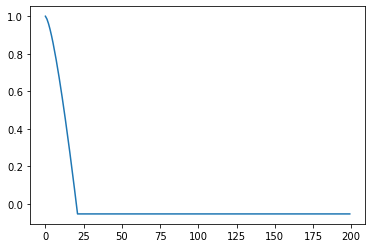

In [ ]:
agent = UCBQAgent()
epsilons = []
for t in range(200):
    epsilons.append(agent.epsilon)
    agent.choose_action(0)

plt.plot(epsilons)

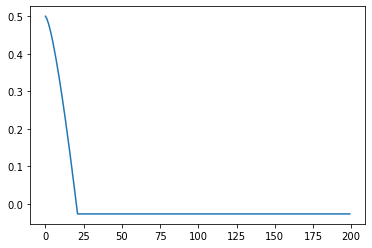

In [ ]:
agent = UCBQAgent()
epsilons = []
for t in range(200):
    epsilons.append(agent.alpha)
    agent.choose_action(0)

plt.plot(epsilons)

# Surrogate rewards without adding noise

In [ ]:
from modified_pendulum_processor_noiseless import ModifiedPendulumProcessorNoiseless

100%|██████████| 20/20 [00:02<00:00,  7.41it/s]


Mean episode length: 61.0
Accuracy: 100.0
[[0.8 0.  0.  0.  0.  0.  0.2]
 [0.  0.8 0.  0.  0.  0.2 0. ]
 [0.  0.  0.8 0.  0.2 0.  0. ]
 [0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.2 0.  0.8 0.  0. ]
 [0.  0.2 0.  0.  0.  0.8 0. ]
 [0.2 0.  0.  0.  0.  0.  0.8]]
{(0, 3): [-3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3], (0, 0): [-6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6], (0, 1): [-5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5], (0, 2): [-4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4], (0, 4): [-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2], (0, 5): [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 

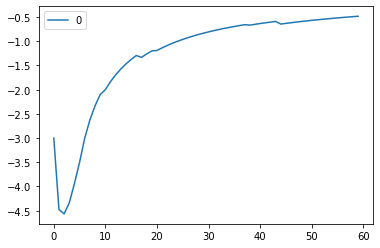

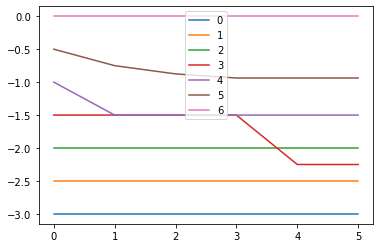

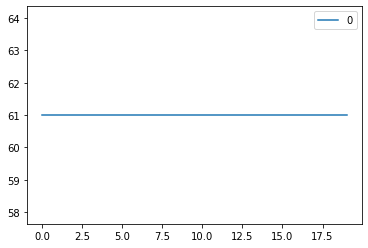

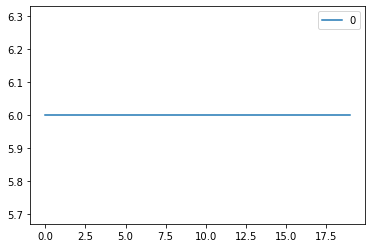

In [ ]:
post_processor_surrogate = ModifiedPendulumProcessorNoiseless()

def adjust_rewards_surrogate(reward, state, action):    
    observation, reward, done, info = post_processor_surrogate.process_step(state, reward, None, None, action)
    return reward

plot_mean_q_values(adjust_rewards_surrogate)

print(post_processor_surrogate.cmat)
print(post_processor_surrogate.r_sets)
print('Estimated confusion matrix:')
print(np.around(post_processor_surrogate.C, decimals=4))